In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv

if not load_dotenv():
    raise FileNotFoundError("No .env file found")

In [3]:
from llm_agents_introduction.alpha_vantage import AlphaVantageService
from llm_agents_introduction.tools.market_data_tools import create_market_data_tools

# create basic set of stock data tools
alpha_vantage = AlphaVantageService.create()
# slightly more advanced set of stock data tools
tools = create_market_data_tools(alpha_vantage)

In [4]:
from datetime import date
from langchain_openai import ChatOpenAI
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.prompts.chat import ChatPromptTemplate

# define assistant chain
model = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
).bind_tools(tools)

system_prompt = """
You are an assistant who answers questions about the stock market.

The current date is: {current_date}
""".strip()

agent_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("messages"),
    ]
)

agent_chain = (
    agent_prompt.partial(current_date=date.today().isoformat()) 
    | model
)

LangGraph provides "prebuilts" to make these typical simple agents much easier to build than I am demonstrating. This is intended to highlight the foundational components of LangGraph in a simple usecase.

In [9]:
from typing import Annotated, TypedDict
from langgraph.graph import END, StateGraph
from langgraph.checkpoint import MemorySaver
from langchain_core.messages import BaseMessage
import operator
from llm_agents_introduction.tools import call_tool


# define the state of the graph
# note the use of operator.add as a "reducer" to make state updates easier
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], operator.add]


# define nodes
def agent(state: AgentState):
    ai_message = agent_chain.invoke(state)

    # note how we're only returning the last message
    # but due to the application of the reducer the eventual state is the full list of messages
    return {"messages": [ai_message]}


def tool_executor(state: AgentState):
    # run the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    tool_call_messages = [call_tool(tool_call, tools) for tool_call in tool_calls]

    return {"messages": tool_call_messages}


# define graph
graph = StateGraph(AgentState)

graph.add_node("agent", agent)
graph.add_node("tool_executor", tool_executor)

graph.set_entry_point("agent")
graph.add_conditional_edges(
    "agent",
    lambda state: "tool_executor" if state["messages"][-1].tool_calls else END,
    [ "tool_executor", END ]
)
graph.add_edge("tool_executor", "agent")


# create checkpointer
checkpointer = MemorySaver()


# create app
app = graph.compile(checkpointer=checkpointer)

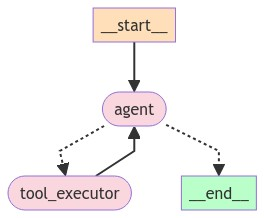

In [10]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [11]:
from langchain_core.messages import HumanMessage
from pprint import pprint

message_text = "Which has the higher stock price - Apple or Webtoon Entertainment?"

initial_state = {"messages": [HumanMessage(content=message_text)]}
config = {"configurable": {"thread_id": "demo"}}

for update in app.stream(initial_state, config=config):
    pprint(update)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gmfqwX5ibzfDae5trobNNbU5', 'function': {'arguments': '{"company_name": "Apple"}', 'name': 'search_for_symbol'}, 'type': 'function'}, {'id': 'call_fzh28Omr4ndbdnGc6vwCluQn', 'function': {'arguments': '{"company_name": "Webtoon Entertainment"}', 'name': 'search_for_symbol'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 267, 'total_tokens': 317}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_d33f7b429e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2ebf4b8c-a1e9-4de2-813c-10c237a1617b-0', tool_calls=[{'name': 'search_for_symbol', 'args': {'company_name': 'Apple'}, 'id': 'call_gmfqwX5ibzfDae5trobNNbU5'}, {'name': 'search_for_symbol', 'args': {'company_name': 'Webtoon Entertainment'}, 'id': 'call_fzh28Omr4ndbdnGc6vwCluQn'}], usage_metadata={'input_tokens': 267, 'output_tokens': 50, 'total_tokens': 317})]}}
{'tool_exec

In [13]:
new_message_state = {"messages": [HumanMessage(content="Compare those to Google")]}

for update in app.stream(new_message_state, config=config):
    pprint(update)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ifSUxgVYqTaZ95DaKXoAd8xe', 'function': {'arguments': '{"company_name":"Google"}', 'name': 'search_for_symbol'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 717, 'total_tokens': 733}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_dd932ca5d1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-83c9f00a-2d68-4af7-9540-0f4316e7e0df-0', tool_calls=[{'name': 'search_for_symbol', 'args': {'company_name': 'Google'}, 'id': 'call_ifSUxgVYqTaZ95DaKXoAd8xe'}], usage_metadata={'input_tokens': 717, 'output_tokens': 16, 'total_tokens': 733})]}}
{'tool_executor': {'messages': [ToolMessage(content='[]', tool_call_id='call_ifSUxgVYqTaZ95DaKXoAd8xe')]}}
{'agent': {'messages': [AIMessage(content='It appears that there are no direct results for "Google" as a company name. Google is a subsidiary of Alphabet Inc. Let me search for Alphabet 

In [16]:
pprint(checkpointer.get(config))

{'channel_values': {'agent': 'agent',
                    'messages': [HumanMessage(content='Which has the higher stock price - Apple or Webtoon Entertainment?'),
                                 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gmfqwX5ibzfDae5trobNNbU5', 'function': {'arguments': '{"company_name": "Apple"}', 'name': 'search_for_symbol'}, 'type': 'function'}, {'id': 'call_fzh28Omr4ndbdnGc6vwCluQn', 'function': {'arguments': '{"company_name": "Webtoon Entertainment"}', 'name': 'search_for_symbol'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 267, 'total_tokens': 317}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_d33f7b429e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2ebf4b8c-a1e9-4de2-813c-10c237a1617b-0', tool_calls=[{'name': 'search_for_symbol', 'args': {'company_name': 'Apple'}, 'id': 'call_gmfqwX5ibzfDae5trobNNbU5'}, {'name': 'search_for_symbol', 'args': {'comp

Example using LangGraph's prebuilt support to make simple tooling agents.

In [14]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState
from langchain_core.runnables import RunnablePassthrough

simple_tools_graph = StateGraph(MessagesState)

simple_tools_graph.add_node("agent", agent_chain | { "messages": RunnablePassthrough() })
simple_tools_graph.add_node(ToolNode(tools))

simple_tools_graph.set_entry_point("agent")
simple_tools_graph.add_conditional_edges("agent", tools_condition)
simple_tools_graph.add_edge("tools", "agent")

simple_agent_app = simple_tools_graph.compile()

simple_agent_app.invoke({
    "messages": HumanMessage(content="How much has Apple's stock price changed in the last year?"),
})

{'messages': [HumanMessage(content="How much has Apple's stock price changed in the last year?", id='a958c53f-c422-4766-9413-6a8f69a5049a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7MgoJo9q2iKHQDO3qWJsSht6', 'function': {'arguments': '{"company_name":"Apple"}', 'name': 'search_for_symbol'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 266, 'total_tokens': 282}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_dd932ca5d1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6f45fe0d-2513-407d-9acd-7904878f8815-0', tool_calls=[{'name': 'search_for_symbol', 'args': {'company_name': 'Apple'}, 'id': 'call_7MgoJo9q2iKHQDO3qWJsSht6'}], usage_metadata={'input_tokens': 266, 'output_tokens': 16, 'total_tokens': 282}),
  ToolMessage(content='[\n  {\n    "symbol": "APLE",\n    "name": "Apple Hospitality REIT Inc"\n  },\n  {\n    "symbol": "AAPL",\n    "name": "Apple Inc"\n  },\n  {\n    "symbol"